In [1]:
import torch
from torch.utils.data import DataLoader,TensorDataset
from torch import nn
from torch.optim import lr_scheduler
import torch.optim as optim


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import math
from mpl_toolkits.mplot3d import Axes3D
from random import uniform




Integrating Adversarial Autoencoders (AAEs) into my fraud detection system could significantly enhance its performance. Currently, my model has a strong recall of 88.95%, effectively detecting a high percentage of true anomalies, but precision stands at 91.69%, indicating some room for improvement. The F1 score of 90.30% shows a good balance, but increasing precision could further boost the model's effectiveness.

By leveraging AAEs, I expect to  address these issues in several ways. The AAE’s ability to generate synthetic fraudulent transactions will help balance my dataset, which is especially useful if the number of fraudulent transactions is limited. This data augmentation will improve the model’s training and help reduce false positives.

Furthermore, AAEs combine autoencoder and adversarial training to enhance anomaly detection. The autoencoder learns to reconstruct normal data, while the adversarial component improves the distinction between real and synthetic data. This dual approach allows for more accurate anomaly classification, which can refine the threshold for detecting anomalies and improve precision.

AAEs also offer advanced feature extraction and representation learning, which can enhance the autoencoder’s ability to identify subtle anomalies. Additionally, AAEs can continuously adapt to new data, ensuring that the anomaly detection system remains effective as transaction patterns evolve.

To implement AAEs, I’ll start by preparing my data with both normal and fraudulent transactions. After training the autoencoder, I'll use the AAE to generate synthetic data and refine anomaly detection. This approach should lead to better precision and overall performance in my fraud detection system

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
main_path = "/home/hernan/Pytorch_scripts/Autoencoders/credit_card/creditcard_2023.csv"  

In [4]:
df = pd.read_csv(main_path)

In [36]:

# Normalize the "Amount" column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))


# Extract features and labels from the entire dataset
X = df.drop(["id", "Class"], axis=1).values  
y = df["Class"].values


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Filter non-fraudulent data (Class = 0) from the training set


X_train_fraud = X_train[y_train == 1]
y_train_fraud = y_train[y_train == 1]


X_train = X_train[y_train == 0]
y_train = y_train[y_train == 0]



# Display dimensions to verify
print("Dimensions of X_train_non_fraud:", X_train.shape)
print("Dimensions of y_train_non_fraud:", y_train.shape)
print("Dimensions of X_train_fraud:", X_train_fraud.shape)
print("Dimensions of y_train_fraud:", y_train_fraud.shape)
print("Dimensions of X_test:", X_test.shape)
print("Dimensions of y_test:", y_test.shape)


# Número de muestras en el conjunto no fraudulento
num_non_fraud_samples = X_train.shape[0]

# Submuestreo del conjunto de datos de fraude
indices_fraud = np.random.choice(X_train_fraud.shape[0], num_non_fraud_samples, replace=False)
X_train_fraud_subsampled = X_train_fraud[indices_fraud]
y_train_fraud_subsampled = y_train_fraud[indices_fraud]

# Verificar dimensiones
print("Dimensions of X_train_fraud_subsampled:", X_train_fraud_subsampled.shape)
print("Dimensions of y_train_fraud_subsampled:", y_train_fraud_subsampled.shape)




# #Standarize data based on mean & std of X_train
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train -mean)/std
X_test = (X_test -mean)/std
X_train_fraud_subsampled = (X_train_fraud_subsampled-mean)/std


# Pass the data to tensors

X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
X_train_fraud_tensor = torch.FloatTensor(X_train_fraud_subsampled)


y_train_tensor = torch.LongTensor(y_train)  
y_test_tensor = torch.LongTensor(y_test)    
y_train_fraud_tensor = torch.LongTensor(y_train_fraud_subsampled)    



# Create DataLoader to handle data in batches
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_dataset_fraud = TensorDataset(X_train_fraud_tensor,y_train_fraud_tensor)

bs = 512

train_loader = DataLoader(
    dataset=train_dataset_fraud,
    batch_size=bs,
    shuffle=True,
    num_workers=8)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=8)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=8)


Dimensions of X_train_non_fraud: (255816, 29)
Dimensions of y_train_non_fraud: (255816,)
Dimensions of X_train_fraud: (255951, 29)
Dimensions of y_train_fraud: (255951,)
Dimensions of X_test: (56863, 29)
Dimensions of y_test: (56863,)
Dimensions of X_train_fraud_subsampled: (255816, 29)
Dimensions of y_train_fraud_subsampled: (255816,)


In [37]:
# Define the Autoencoder with GAN
##model definition

# Define the Autoencoder with GAN
# class Autoencoder(nn.Module):
#     def __init__(self, latent_dim):
#         super(Autoencoder, self).__init__()
        
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Linear(29, 512),
#             nn.BatchNorm1d(512),
#             nn.LeakyReLU(0.3),
#             nn.Dropout(0.3),
#             nn.Linear(512, 256),
#             nn.BatchNorm1d(256),
#             nn.LeakyReLU(0.3),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),
#             nn.LeakyReLU(0.3),
#             nn.Dropout(0.3),
#             nn.Linear(128, 64),
#             nn.BatchNorm1d(64),
#             nn.LeakyReLU(0.3),
#             nn.Dropout(0.3),
#             nn.Linear(64, 32),
#             nn.BatchNorm1d(32),
#             nn.LeakyReLU(0.3),
#             nn.Linear(32, latent_dim)  # Latent dimension
#         )
        
#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 32),
#             nn.LeakyReLU(0.3),
#             nn.Linear(32, 64),
#             nn.LeakyReLU(0.3),
#             nn.Linear(64, 128),
#             nn.LeakyReLU(0.3),
#             nn.Linear(128, 256),
#             nn.LeakyReLU(0.3),
#             nn.Linear(256, 512),
#             nn.LeakyReLU(0.3),
#             nn.Linear(512, 29),
#             nn.Tanh()  # Output layer with Tanh to handle negative values
#         )
    
#     def forward(self, x):
#         z = self.encoder(x)
#         return self.decoder(z)


# class Discriminator(nn.Module):
#     def __init__(self, latent_dim):
#         super(Discriminator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(latent_dim, 256),
#             nn.LeakyReLU(0.2),
#             nn.Linear(256, 128),
#             nn.LeakyReLU(0.2),
#             nn.Linear(128, 64),
#             nn.LeakyReLU(0.2),
#             nn.Linear(64, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, x):
#         return self.model(x)


In [38]:
##Second model more layer an neuron
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(29, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.3),
            nn.Linear(32, latent_dim)  # Latent dimension
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.LeakyReLU(0.3),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.3),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.3),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.3),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.3),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.3),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.3),
            nn.Linear(2048, 29),
            nn.Tanh()  # Output layer with Tanh to handle negative values
        )
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [39]:

# Hyperparameters
latent_dim = 16
LR_ae = 0.001
LR_d = 0.0000001
NUM_EPOCHS = 20

# Initialize models
autoencoder = Autoencoder(latent_dim=latent_dim).to(device)
discriminator = Discriminator(latent_dim=latent_dim).to(device)

# Loss functions and optimizers
criterion_recon = nn.MSELoss()
criterion_adv = nn.BCELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=LR_ae,weight_decay=1e-5)
optimizer_d = optim.Adam(discriminator.parameters(), lr=LR_d,weight_decay=1e-5)

# Training loop
for epoch in range(NUM_EPOCHS):
    autoencoder.train()
    discriminator.train()
    train_loss = 0
    num_samples = 0
    d_loss_total = 0

    if epoch % 2 == 0:
        # Train Discriminator
        for _ in range(1):
            
            for batch in train_loader:
                X_batch, _ = batch
                X_batch = X_batch.to(device)
                batch_size = X_batch.size(0)

                discriminator.zero_grad()

                # Real and fake labels
                real_z = autoencoder.encoder(X_batch)
                real_labels = torch.ones(batch_size, 1).to(device)
                fake_labels = torch.zeros(batch_size, 1).to(device)

                # Discriminator on real data
                real_validity = discriminator(real_z)
                d_loss_real = criterion_adv(real_validity, real_labels)

                # Discriminator on fake data 
                random_tensor = torch.randn(batch_size, latent_dim)  # Tensor aleatorio
                fake_z = torch.randn(batch_size, latent_dim).to(device)  # Random noise
                fake_validity = discriminator(fake_z)
                d_loss_fake = criterion_adv(fake_validity, fake_labels)

                # Total discriminator loss
                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                optimizer_d.step()
                d_loss_total += d_loss.item() * batch_size

            avg_d_loss = d_loss_total / len(train_loader.dataset)  # Average per sample
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Discriminator Loss: {avg_d_loss:.4f}')

    else:
        for _ in range(2):
            
            # Train Autoencoder (Generator)
            for batch in train_loader:
                X_batch, _ = batch
                X_batch = X_batch.to(device)
                batch_size = X_batch.size(0)

                autoencoder.zero_grad()

                # Autoencoder reconstruction
                recon_data = autoencoder(X_batch)
                recon_loss = criterion_recon(recon_data, X_batch)

                # Adversarial loss
                encoded_z = autoencoder.encoder(X_batch)
                validity = discriminator(encoded_z)

                # Use the same label shape as the discriminator output
                real_labels = torch.ones(batch_size, 1).to(device)
                adv_loss = criterion_adv(validity, real_labels)

                # Total autoencoder loss
                ae_loss = recon_loss + adv_loss
                ae_loss.backward()
                optimizer_ae.step()

                train_loss += ae_loss.item() * batch_size
                num_samples += batch_size

        avg_train_loss = train_loss / num_samples
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_train_loss:.4f}')




Epoch [1/20], Discriminator Loss: 1.3821
Epoch [2/20], Loss: 1.2168
Epoch [3/20], Discriminator Loss: 0.9787
Epoch [4/20], Loss: 0.7582
Epoch [5/20], Discriminator Loss: 0.7462
Epoch [6/20], Loss: 0.6087
Epoch [7/20], Discriminator Loss: 0.6933
Epoch [8/20], Loss: 0.5558
Epoch [9/20], Discriminator Loss: 0.6758
Epoch [10/20], Loss: 0.5232
Epoch [11/20], Discriminator Loss: 0.6670
Epoch [12/20], Loss: 0.5077
Epoch [13/20], Discriminator Loss: 0.6615
Epoch [14/20], Loss: 0.5028
Epoch [15/20], Discriminator Loss: 0.6576
Epoch [16/20], Loss: 0.4890
Epoch [17/20], Discriminator Loss: 0.6546
Epoch [18/20], Loss: 0.4817
Epoch [19/20], Discriminator Loss: 0.6519
Epoch [20/20], Loss: 0.4779


Training reconstruction loss: 0.4317
Precision: 0.9205
Recall: 0.8943
F1 Score: 0.9072
Number of anomalies detected: 27558 vs Number of anomalies: 28364


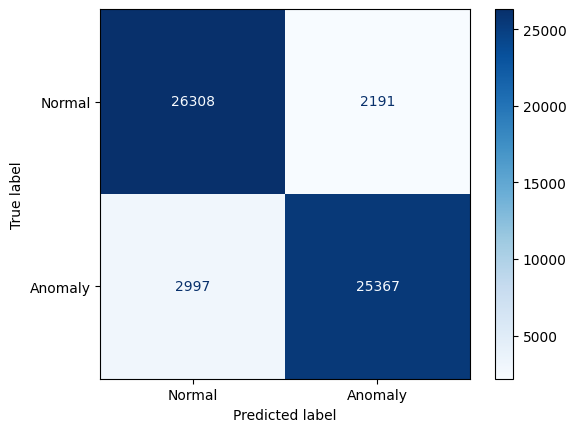

In [43]:

# Count the number of anomalies in the test set
num_anomalies_test = np.sum(y_test == 1)

# Define the loss function
criterion = nn.MSELoss()

# Set the model to evaluation mode
autoencoder.eval()

# Calculate reconstruction error on the training set
with torch.no_grad():
    X_train_tensor = X_train_tensor.to(device)
    reconstructions_train = autoencoder(X_train_tensor)
    train_loss = criterion(reconstructions_train, X_train_tensor)

print(f'Training reconstruction loss: {train_loss.item():.4f}')

# Set threshold as a multiple of the training set loss
threshold = train_loss.item() * 1.522
# Detect anomalies on the test set
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    reconstructions_test = autoencoder(X_test_tensor)
    test_loss = torch.mean((reconstructions_test - X_test_tensor) ** 2, dim=1).cpu().numpy()

# Create binary predictions based on the threshold
y_pred_binary = (test_loss > threshold).astype(int)

# Evaluate the model
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
num_anomalies_detected = np.sum(y_pred_binary)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Number of anomalies detected: {num_anomalies_detected} vs Number of anomalies: {num_anomalies_test}')

# Convert true labels to binary (1 for anomaly, 0 for normal)
y_true_binary = (y_test == 1).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true_binary, y_pred_binary)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap='Blues', values_format='d')
plt.show()


/tmp/ipykernel_911568/2077335522.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


<bound method Axes3D.set of <Axes3D: title={'center': 'Test Data in 3D PCA Space'}, xlabel='PCA Component 1', ylabel='PCA Component 2', zlabel='PCA Component 3'>>

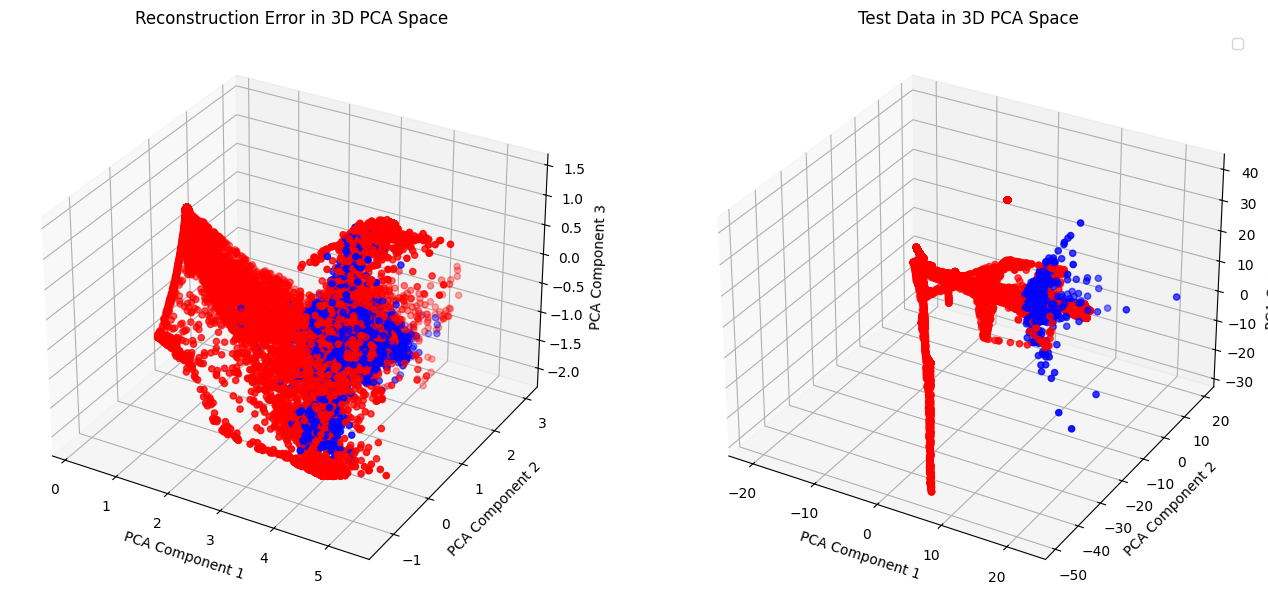

In [44]:

# Evaluate the model and visualize in PCA space
autoencoder.eval()
discriminator.eval()

reconstructed_data = []
original_data = []
anomalies = []

with torch.no_grad():
    for batch in test_loader:
        X_batch, _ = batch
        X_batch = X_batch.to(device)
        
        recon_batch = autoencoder(X_batch)
        reconstructed_data.append(recon_batch.cpu().numpy())
        original_data.append(X_batch.cpu().numpy())

        reconstruction_error = torch.mean((recon_batch - X_batch) ** 2, dim=1)
        anomalies.extend((reconstruction_error > threshold).cpu().numpy())

reconstructed_data = np.concatenate(reconstructed_data, axis=0)
original_data = np.concatenate(original_data, axis=0)

# PCA reduction 
pca = PCA(n_components=3)
original_data_reduced = pca.fit_transform(original_data)
reconstructed_data_reduced = pca.transform(reconstructed_data)

# Colors for the points: 'r' for anomalies and 'b' for normals
colors_anomalies = ['r' if x else 'b' for x in anomalies]
colors_fraud = ['r' if x == 1 else 'b' for x in y_test]

# Configure the figure and axes
fig = plt.figure(figsize=(16, 12))

# First plot: Reconstruction Error
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(reconstructed_data_reduced[:, 0], reconstructed_data_reduced[:, 1], reconstructed_data_reduced[:, 2],
                       c=colors_anomalies, marker='o')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.set_title('Reconstruction Error in 3D PCA Space')

# Second plot: Fraud Detection
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(original_data_reduced[:, 0], original_data_reduced[:, 1], original_data_reduced[:, 2],
                       c=colors_fraud, marker='o')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.set_zlabel('PCA Component 3')
ax2.set_title('Test Data in 3D PCA Space')
ax2.legend()

ax2.set


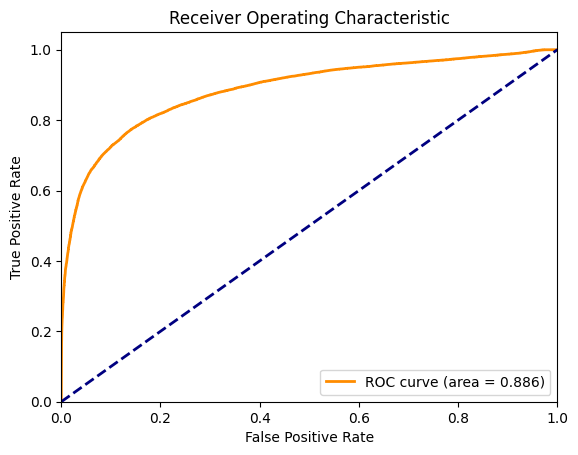

AUC: 0.8864


In [45]:
from sklearn.metrics import roc_curve, auc

def calculate_roc_auc(autoencoder, discriminator, data_loader):
    autoencoder.eval()
    discriminator.eval()
    
    real_labels = []
    pred_scores = []
    
    with torch.no_grad():
        for batch in data_loader:
            X_batch, y_batch = batch
            X_batch = X_batch.to(device)
            batch_size = X_batch.size(0)
            
            # Autoencoder encoding
            fake_z = autoencoder.encoder(X_batch)
            validity = discriminator(fake_z).cpu().numpy()
            
            # Collecting real labels and predicted scores
            real_labels.extend(y_batch.cpu().numpy())
            pred_scores.extend(validity)
    
    # Calculate ROC and AUC
    fpr, tpr, _ = roc_curve(real_labels, pred_scores)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc

# Calculate ROC and AUC for the test dataset
fpr, tpr, roc_auc = calculate_roc_auc(autoencoder, discriminator, test_loader)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {roc_auc:.4f}')
